# LLSQ Fit
Use background corrected reference spectra to fit an unknown. 

In [1]:
using NeXLSpectrum
using DataFrames, Gadfly, CSV
using LinearAlgebra

┌ Info: Precompiling NeXLSpectrum [6c578565-ca7f-4012-afc4-b8412d85af92]
└ @ Base loading.jl:1313
┌ Info: Loading Gadfly support into NeXLSpectrum.
└ @ NeXLSpectrum C:\Users\nritchie\.julia\dev\NeXLSpectrum\src\gadflysupport.jl:513


Load the unknown spectrum and the reference spectra.  Plot them.

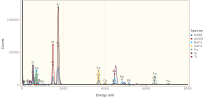

In [9]:
path = joinpath(@__DIR__,"K309")
unk = loadspectrum(joinpath(path, "K309.msa"))
unk[:Composition]=mat"0.3872*O+0.0794*Al+0.1870*Si+0.1072*Ca+0.1049*Fe+0.1343*Ba"
unk[:Coating]=Film(parse(Material,"C",density=1.9),10.0e-7)
stds = map(("Al2O3", "BaF2", "CaF2", "Fe", "Si", "Ti" )) do fn 
  s = loadspectrum(joinpath(path,"$fn std.msa"))
  s[:Composition]=parse(Material,fn)
  s[:Coating]=Film(parse(Material,"C",density=1.9),10.0e-7)
  s
end
elems = collect(elms(unk, true))
set_default_plot_size(8inch,4inch)
plot(unk,stds...,klms=elems,xmax=8.0e3)

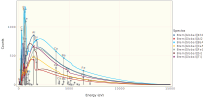

In [10]:
det = matching(unk,132.0, 110)
resp = detectorresponse(det,SDDEfficiency(AP33Model()))

unkb = fittedcontinuum(unk, det, resp)
stdsb = map(s->fittedcontinuum(s, det, resp), stds)

plot(unkb,stdsb...,klms=elems,xmax=15.0e3)


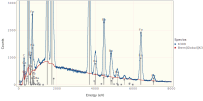

In [11]:
plot(unk,unkb,autoklms=true,xmax=8.0e3, yscale=0.1)

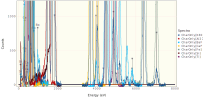

In [12]:
unkc = subtractcontinuum(unk, det, resp)
stdsc = map(s->subtractcontinuum(s, det, resp), stds)
plot(unkc, stdsc..., autoklms=true, xmax=8.0e3, yscale=0.01)

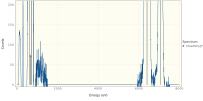

In [13]:
plot(stdsc[4], autoklms=true, xmax=8.0e3, yscale=0.01)

In [88]:
function fit_spectrum(
    spec::Spectrum, 
    refs::Dict{Element, <:Spectrum}, 
    det::EDSDetector,
    resp::AbstractArray{<:Real,2};
    brem::Type{<:NeXLBremsstrahlung} = Castellano2004a,
    mc::Type{<:MatrixCorrection} = Riveros1993,
 )# ::Vector{KRatio}
  cuds = []
  for (elm, ref) in refs
    cmod = ContinuumModel(
         ref[:Composition],
         ref[:BeamEnergy],
         ref[:TakeOffAngle],
         matrixcorrection = mc,
         bremsstrahlung = brem)
    model = resp * map(e -> e > 50.0 ? emitted(cmod, e) : 0.0, energyscale(spec))
    cud = map(NeXLSpectrum.labeledextents(characteristic(elm, alltransitions, 0.001), det, 0.001)) do le
       cxrs, ur = le 
       ( cxrs, ur, ref[ur]-model[ur], ref )
    end
    append!(cuds, cud)  
  end
  ascontiguous = let
    scuds = sort(cuds, lt=(c1,c2)->first(c1[2])<first(c2[2]))
    res = [ scuds[1][2] ]
    for (_, roi, _, _) in scuds[2:end]
      if length(intersect(res[end], roi)) > 0
        res[end] = min(first(roi), first(res[end])):max(last(roi), last(res[end]))
      else
        push!(res, roi)
      end
    end
    res
  end
  cmod = ContinuumModel(
         unk[:Composition],
         unk[:BeamEnergy],
         unk[:TakeOffAngle],
         matrixcorrection = mc,
         bremsstrahlung = brem)
  model = resp * map(e -> e > 50.0 ? emitted(cmod, e) : 0.0, energyscale(spec))
  y = counts(unk) - model
  res = UncertainValues[]
  for roi in ascontiguous
    fcuds = filter(cud->length(intersect(cud[2], roi))>0, cuds)
    a = zeros(Float64, (length(roi), length(fcuds)))
    labels, scales = Label[], Float64[]
    for (i, cud) in enumerate(fcuds)
      (cxrs, croi, cdata, cref) = cud
      a[first(croi)-first(roi)+1:last(croi)-first(roi)+1,i] = cdata
      push!(labels, CharXRayLabel(spec, croi, cxrs))
      push!(scales, dose(unk)/dose(cref))
    end
    push!(res, diagm(scales)*NeXLSpectrum.olspinv(y[roi],a,1.0,labels))
  end
  return cat(res...)
end

fit_spectrum (generic function with 3 methods)

In [91]:
refs = Dict(n"O"=>stds[1],n"Ba"=>stds[2],n"Ca"=>stds[3],n"Fe"=>stds[4],n"Si"=>stds[5],n"Ti"=>stds[6])
fit_spectrum(unk,refs,det,resp)

| Labels                                                                                                                                        | Values                                                                                                                                        |                                                                                                                                               | k[Ti L3-M1 + 6 others,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]  | k[Fe L3-M5 + 9 others,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]  | k[O K-L3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]     | k[Si K-L3 + 2 others,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]   | k[Ba L3-M1,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]             | k[Ca K-L3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    | k[Ca K-M3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    | k[Ti K-L3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    | k[Ti K-M3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    | k[Ba L3-M5 + 17 others,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]] | k[Fe K-L3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    | k[Fe K-M3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    |
| :-------------------------------------------------------------------------------------------------------------------------------------------- | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------------------------------------------------------------------------------: |
| k[Ti L3-M1 + 6 others,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]  | 6.92e-02                                                                                                                                      |                                                                                                                                               | (7.81e-05)²                                                                                                                                   | 1.02e-11                                                                                                                                      | -2.03e-10                                                                                                                                     | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      |
| k[Fe L3-M5 + 9 others,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]  | 1.93e-01                                                                                                                                      |                                                                                                                                               | 1.02e-11                                                                                                                                      | (2.46e-05)²                                                                                                                                   | -3.20e-12                                                                                                                                     | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      |
| k[O K-L3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]     | 1.57e+00                                                                                                                                      |                                                                                                                                               | -2.03e-10                                                                                                                                     | -3.20e-12                                                                                                                                     | (1.88e-05)²                                                                                                                                   | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      |
| k[Si K-L3 + 2 others,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]   | 3.49e-01                                                                                                                                      |                                                                                                                                               | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | (3.92e-06)²                                                                                                                                   | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      |
| k[Ba L3-M1,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]             | 1.01e+00                                                                                                                                      |                                                                                                                                               | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | (1.21e-03)²                                                                                                                                   | -4.64e-11                                                                                                                                     | -2.13e-07                                                                                                                                     | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      |
| k[Ca K-L3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    | 5.26e-01                                                                                                                                      | ±                                                                                                                                             | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | -4.64e-11                                                                                                                                     | (1.88e-05)²                                                                                                                                   | 6.73e-12                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      |
| k[Ca K-M3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    | 5.37e-01                                                                                                                                      |                                                                                                                                               | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | -2.13e-07                                                                                                                                     | 6.73e-12                                                                                                                                      | (2.34e-04)²                                                                                                                                   | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      |
| k[Ti K-L3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    | 7.01e-04                                                                                                                                      |                                                                                                                                               | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | (1.97e-05)²                                                                                                                                   | 5.58e-10                                                                                                                                      | -7.67e-10                                                                                                                                     | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      |
| k[Ti K-M3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    | 4.07e-02                                                                                                                                      |                                                                                                                                               | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 5.58e-10                                                                                                                                      | (1.17e-04)²                                                                                                                                   | -2.04e-09                                                                                                                                     | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      |
| k[Ba L3-M5 + 17 others,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]] | 3.77e-01                                                                                                                                      |                                                                                                                                               | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | -7.67e-10                                                                                                                                     | -2.04e-09                                                                                                                                     | (5.30e-05)²                                                                                                                                   | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      |
| k[Fe K-L3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    | 2.33e-01                                                                                                                                      |                                                                                                                                               | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | (2.86e-05)²                                                                                                                                   | 0.00e+00                                                                                                                                      |
| k[Fe K-M3 + 1 other,0.3872×O+0.0794×Al+0.187×Si+0.1072×Ca+0.1049×Fe+0.1343×Ba[Al=0.0794,Ba=0.1343,Ca=0.1072,Fe=0.1049,O=0.3872,Si=0.1870]]    | 3.16e-01                                                                                                                                      |                                                                                                                                               | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | 0.00e+00                                                                                                                                      | (2.27e-04)²                                                                                                                                   |